In [12]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # or set to the number of physical cores on your machine

# -----------------------------
# Load Data
# -----------------------------
train_set = pd.read_csv("../0_DataPreparation/train_set.csv")
validation_set = pd.read_csv("../0_DataPreparation/validation_set.csv")

baseline_features = [
    'Warengruppe',
    'Temperatur',
    'Bewoelkung',
    'KielerWoche',
    'Feiertag',
    'Monat',
    'avg_sales_per_group_dayofyear'
]
target = 'Umsatz'

# -----------------------------
# Define Feature Types
# -----------------------------
categorical_features = ['Warengruppe', 'KielerWoche', 'Feiertag', 'Monat']
numerical_features = ['Temperatur', 'Bewoelkung', 'avg_sales_per_group_dayofyear']

# -----------------------------
# Preprocessing Pipelines
# -----------------------------
inf_to_nan = FunctionTransformer(
    lambda X: np.where(np.isinf(X), np.nan, X),
    feature_names_out='one-to-one'
)

numeric_pipeline = Pipeline([
    ('inf_to_nan', inf_to_nan),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))

])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# -----------------------------
# Final Model Pipeline
# -----------------------------
model_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', HistGradientBoostingRegressor(random_state=42))
])

# -----------------------------
# Train Model
# -----------------------------
X_train = train_set[baseline_features]
y_train = train_set[target]
X_val = validation_set[baseline_features]
y_val = validation_set[target]

print("Training model...")
model_pipeline.fit(X_train, y_train)

# -----------------------------
# Evaluation Function
# -----------------------------
def evaluate_model(model, X, y, set_name):
    pred = model.predict(X)
    mse = mean_squared_error(y, pred)
    r2 = r2_score(y, pred)
    mape = np.mean(np.abs((y - pred) / np.where(y == 0, 1, y))) * 100

    print(f"\n{set_name} Set Performance:")
    print(f"- R²: {r2:.4f}")
    print(f"- MAPE: {mape:.2f}%")

def evaluate_model(model, X, y, set_name, show_adjusted=False):
    pred = model.predict(X)
    mse = mean_squared_error(y, pred)
    r2 = r2_score(y, pred)
    mape = np.mean(np.abs((y - pred) / np.where(y == 0, 1, y))) * 100

    print(f"\n{set_name} Set Performance:")
    print(f"- R²: {r2:.4f}")
    
    if show_adjusted:
        n = len(y)
        p = model.named_steps['preprocess'].transform(X).shape[1]  # number of features after preprocessing
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        print(f"- Adjusted R²: {adj_r2:.4f}")

    print(f"- MAPE: {mape:.2f}%")
evaluate_model(model_pipeline, X_train, y_train, "TRAINING", show_adjusted=True)
evaluate_model(model_pipeline, X_val, y_val, "VALIDATION")

    



Training model...

TRAINING Set Performance:
- R²: 0.8966
- Adjusted R²: 0.8962
- MAPE: 19.44%

VALIDATION Set Performance:
- R²: 0.8179
- MAPE: 23.53%


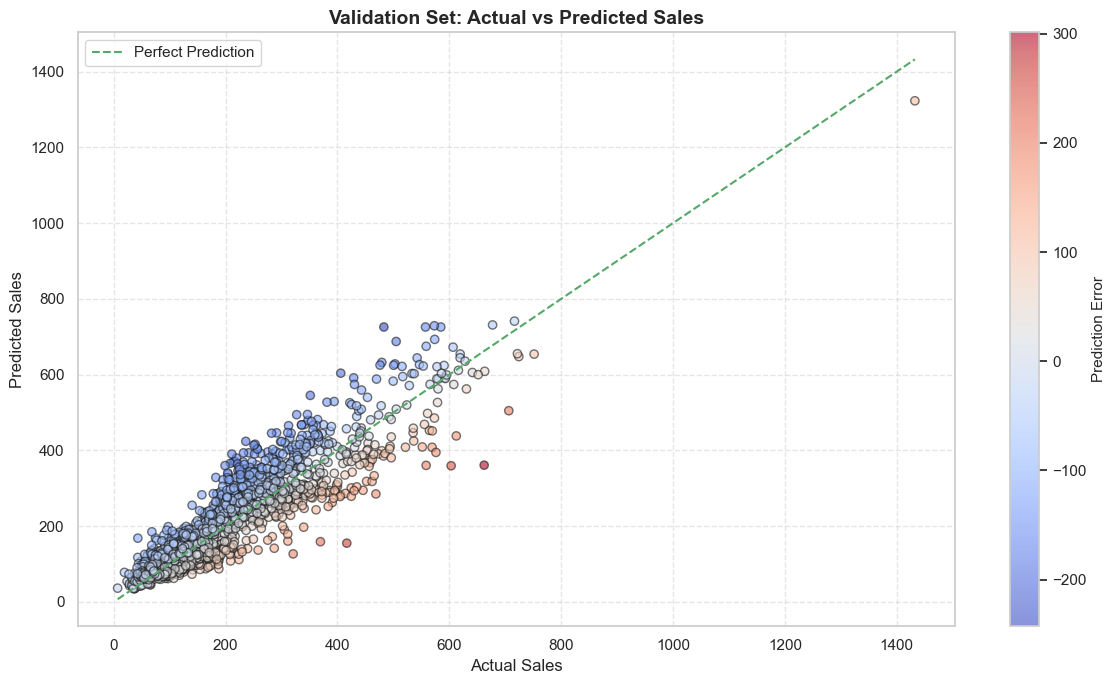

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on validation set
y_pred_val = model_pipeline.predict(X_val)

# Calculate error
errors = y_val - y_pred_val

# Plot
plt.figure(figsize=(12, 7))
sns.set(style="whitegrid")

# Scatter plot with color-coded errors
sc = plt.scatter(y_val, y_pred_val, c=errors, cmap='coolwarm', edgecolor='k', alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'g--', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Sales", fontsize=12)
plt.ylabel("Predicted Sales", fontsize=12)
plt.title("Validation Set: Actual vs Predicted Sales", fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Prediction Error", fontsize=11)

# Extras
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


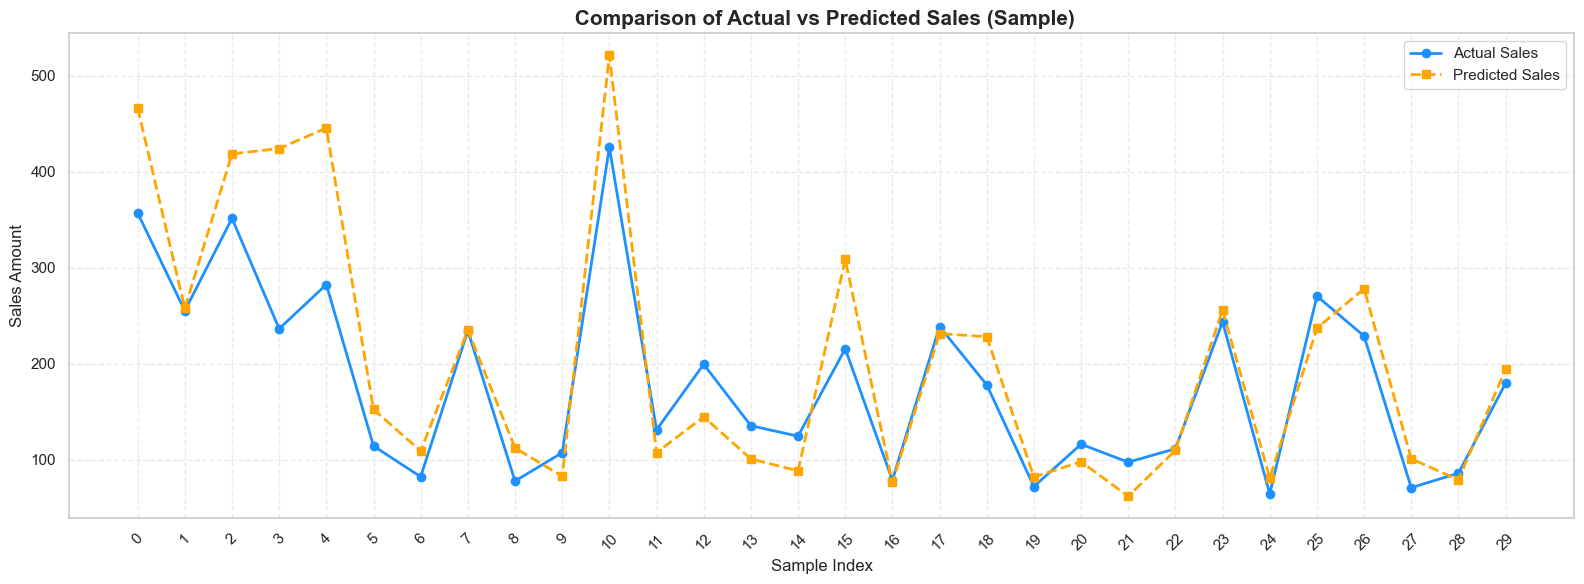

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Predict on validation set
y_pred_val = model_pipeline.predict(X_val)

# Select a sample to visualize
sample_size = 30
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(len(y_val), sample_size, replace=False)

# Actual vs Predicted
actual = y_val.iloc[sample_indices].reset_index(drop=True)
predicted = pd.Series(y_pred_val[sample_indices], name="Predicted")

# Styling
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))

# Plot
plt.plot(actual, label='Actual Sales', color='dodgerblue', marker='o', linestyle='-', linewidth=2)
plt.plot(predicted, label='Predicted Sales', color='orange', marker='s', linestyle='--', linewidth=2)

# Visuals
plt.title(" Comparison of Actual vs Predicted Sales (Sample)", fontsize=15, fontweight='bold')
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Sales Amount", fontsize=12)
plt.xticks(np.arange(sample_size), rotation=45)
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
